### Import Library

In [12]:
import pandas as pd
import os
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import warnings
from scipy.spatial import ConvexHull
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.colors as mcolors
from adjustText import adjust_text
from matplotlib.lines import Line2D

### Define the functions

In [13]:
# Function to create a dissimilarity matrix from the data
def create_dissimilarity_matrix(data, complex_tone_names, everydaysound_names):
    stimuli = complex_tone_names + everydaysound_names #TBFixed
    matrix = np.full((len(stimuli), len(stimuli)), np.nan)  # Initialize with NaN values
    np.fill_diagonal(matrix, 0)
    for _, row in data.iterrows():
        i = stimuli.index(row['Spreadsheet: A'].replace('.wav', ''))
        j = stimuli.index(row['Spreadsheet: B'].replace('.wav', ''))
        matrix[i, j] = matrix[j, i] = row['Response']
    
    # Check for NaN values and fill them symmetrically
    if np.isnan(matrix).any():
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if np.isnan(matrix[i, j]):
                    random_value = np.random.randint(0, 7)
                    matrix[i, j] = matrix[j, i] = random_value
        warnings.warn("Input X contains NaN and has been filled symmetrically with random values.")
    
    return matrix

def plot_individual_MDS(coordinates_dict, stimuli, complex_tone_names, output_csv_path):
    n_subjects = len(coordinates_dict)
    fig, ax = plt.subplots(nrows=n_subjects, ncols=1, figsize=(8, n_subjects * 5))
    axes = ax if n_subjects > 1 else [ax]  # Ensure axes is always a list
    for ax, (participant, coords) in zip(axes, coordinates_dict.items()):
        for i, stimulus in enumerate(stimuli):
            category = "complex_tone" if stimulus in complex_tone_names else "everydaysound"
            color = 'red' if category == "complex_tone" else 'green'
            ax.scatter(coords[i, 0], coords[i, 1], color=color, alpha=0.6)
            ax.annotate(stimulus.replace('.wav', ''), (coords[i, 0], coords[i, 1]))
        
        x_min, x_max = -6, 6  # example values, adjust as necessary
        y_min, y_max = -6, 6  # example values, adjust as necessary
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_title(f"Participant {participant}")
        #ax.axis('equal')

    plt.tight_layout()
    
    # Save the individual MDS plot
    plot_individual_path = os.path.join(os.path.dirname(output_csv_path), "individual_mds_plot.png")
    plt.savefig(plot_individual_path)
    plt.show()


def plot_average_MDS(coordinates, stimuli, complex_tone_names, output_csv_path):
    for i, stimulus in enumerate(stimuli):
        category = "complex_tone" if stimulus in complex_tone_names else "everydaysound"
        color = 'red' if category == "complex_tone" else 'green'
        plt.scatter(coordinates[i, 0], coordinates[i, 1], color=color, alpha=0.3)
        plt.annotate(stimulus.replace('.wav', ''), (coordinates[i, 0], coordinates[i, 1]))

    # Average across categories
    avg_coords_complex = np.mean(coordinates[:len(complex_tone_names)], axis=0)
    avg_coords_everyday = np.mean(coordinates[len(complex_tone_names):], axis=0)
    plt.scatter(avg_coords_complex[0], avg_coords_complex[1], color='red', marker='*', s=100, label='Average Complex Tone')
    plt.scatter(avg_coords_everyday[0], avg_coords_everyday[1], color='green', marker='*', s=100, label='Average Everyday Sound')
    
    # After plotting all the data points
    x_min, x_max = -6, 6  # example values, adjust as necessary
    y_min, y_max = -6, 6  # example values, adjust as necessary

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend()
    plt.title("Average MDS")
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    
    # Save the average MDS plot
    plot_average_path = os.path.join(os.path.dirname(output_csv_path), "average_mds_plot.png")
    plt.savefig(plot_average_path)
    plt.show()


def plot_average_MDS_with_hulls(average_coordinates, stimuli, complex_tone_names, everydaysound_names, output_csv_path):
    
    new_complex_tone_names = ['C4', 'D4', 'E4', 'F#4', 'G4', 'G#4', 'A4', 'C#5', 'D#5']
    complex_tone_rename = dict(zip(complex_tone_names, new_complex_tone_names))

    # Rename everyday sounds by removing '_3ms' and handle specific replacements
    new_everydaysound_names = [sound.replace('_3ms', '') for sound in everydaysound_names]
    new_everydaysound_names = [sound.replace('car_engine', 'car') for sound in new_everydaysound_names]
    new_everydaysound_names = [sound.replace('sizzling_pan', 'sizzling') for sound in new_everydaysound_names]
    everydaysound_rename = dict(zip(everydaysound_names, new_everydaysound_names))

    plt.figure(figsize=(10, 10))

    texts = []
    # Modify the annotate section:
    for i, stimulus in enumerate(stimuli):
        category = "complex_tone" if stimulus in complex_tone_names else "everydaysound"
        color = 'red' if category == "complex_tone" else 'green'
        marker = 'o'
        plt.scatter(average_coordinates[i, 0], average_coordinates[i, 1], color=color, marker=marker, alpha=1, s=100)

        # Check rename
        new_name = stimulus
        if category == "complex_tone" and stimulus in complex_tone_rename:
            new_name = complex_tone_rename[stimulus]
        elif category == "everydaysound" and stimulus in everydaysound_rename:
            new_name = everydaysound_rename[stimulus]

        text = plt.annotate(new_name, (average_coordinates[i, 0], average_coordinates[i, 1]), fontsize = 20)
        texts.append(text)

    # Create convex hulls
    for category, color in [("complex_tone", "red"), ("everydaysound", "green")]:
        relevant_stimuli = complex_tone_names if category == "complex_tone" else everydaysound_names
        relevant_indices = [stimuli.index(stim) for stim in relevant_stimuli if stim in stimuli]
        
        relevant_coords = average_coordinates[relevant_indices]
        
        hull = ConvexHull(relevant_coords)
        for simplex in hull.simplices:
            plt.plot(relevant_coords[simplex, 0], relevant_coords[simplex, 1], color, alpha=0.7)

    x_min, x_max = -6, 6
    y_min, y_max = -6, 6
    plt.grid(True) 

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.tick_params(axis='x', labelsize=22)
    plt.tick_params(axis='y', labelsize=22)

    # Custom legend
    legend_elements = [Line2D([0], [0], color='red', marker='o', label='Broadband Complex Tone', markersize=10, alpha=1),
                       Line2D([0], [0], color='green', marker='o', label='Everyday Sound', markersize=10, alpha=1)]
    plt.legend(handles=legend_elements, loc='upper left', fontsize = 22)

    plt.xlabel("MDS Dimension 1", fontsize = 26)
    plt.ylabel("MDS Dimension 2", fontsize = 26)

    adjust_text(texts)

    plot_path = os.path.join(os.path.dirname(output_csv_path), "average_mds_plot_with_hulls.png")
    plt.savefig(plot_path)
    plt.show()



### MDS plots

In [14]:
# Step 1: Define the WAV file names
complex_tone_names = ['C4', 'D4', 'E4', 'Fs4_Gb4', 'G4', 'Gs4_Ab4', 'A4', 'Cs5_Db5', 'Ds5_Eb5']
everydaysound_names = ['baby_3ms', 'bell_3ms', 'frog_3ms', 'car_engine_3ms', 'cough_3ms', 'snore_3ms', 'sheep_3ms', 'sizzling_pan_3ms', 'laugh_3ms']

# Step 2: Process the input CSV file
input_csv_path = '/Volumes/T7/CMU LiMN Research/Perceptual Organization/Result & Analysis/perceptual-similarity-complexTone_everydaySound/data/prolific-8-29/data_exp_141710-v5/data_exp_141710-v5_task-lwvw.csv'  # Replace with your input CSV file path
output_csv_path = '/Volumes/T7/CMU LiMN Research/Perceptual Organization/Result & Analysis/perceptual-similarity-complexTone_everydaySound/result/prolific-pilot_result'+'/processed_ratings.csv'  # Name of the output CSV file

# Read the CSV file using pandas
data = pd.read_csv(input_csv_path)

# Filter the data
filtered_data = data[data['Component Name'] == 'Rating Scale'][['Component Name', 'Participant Private ID', 'Spreadsheet: A', 'Spreadsheet: B','Response']]

# Save the filtered data to a new CSV file
filtered_data.to_csv(output_csv_path, index=False)

# Read the Processed CSV
data = pd.read_csv(output_csv_path)

/var/folders/y9/0k_9rd192c3cw4x9z34p1_zr0000gn/T/ipykernel_42074/1410877832.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_csv_path)


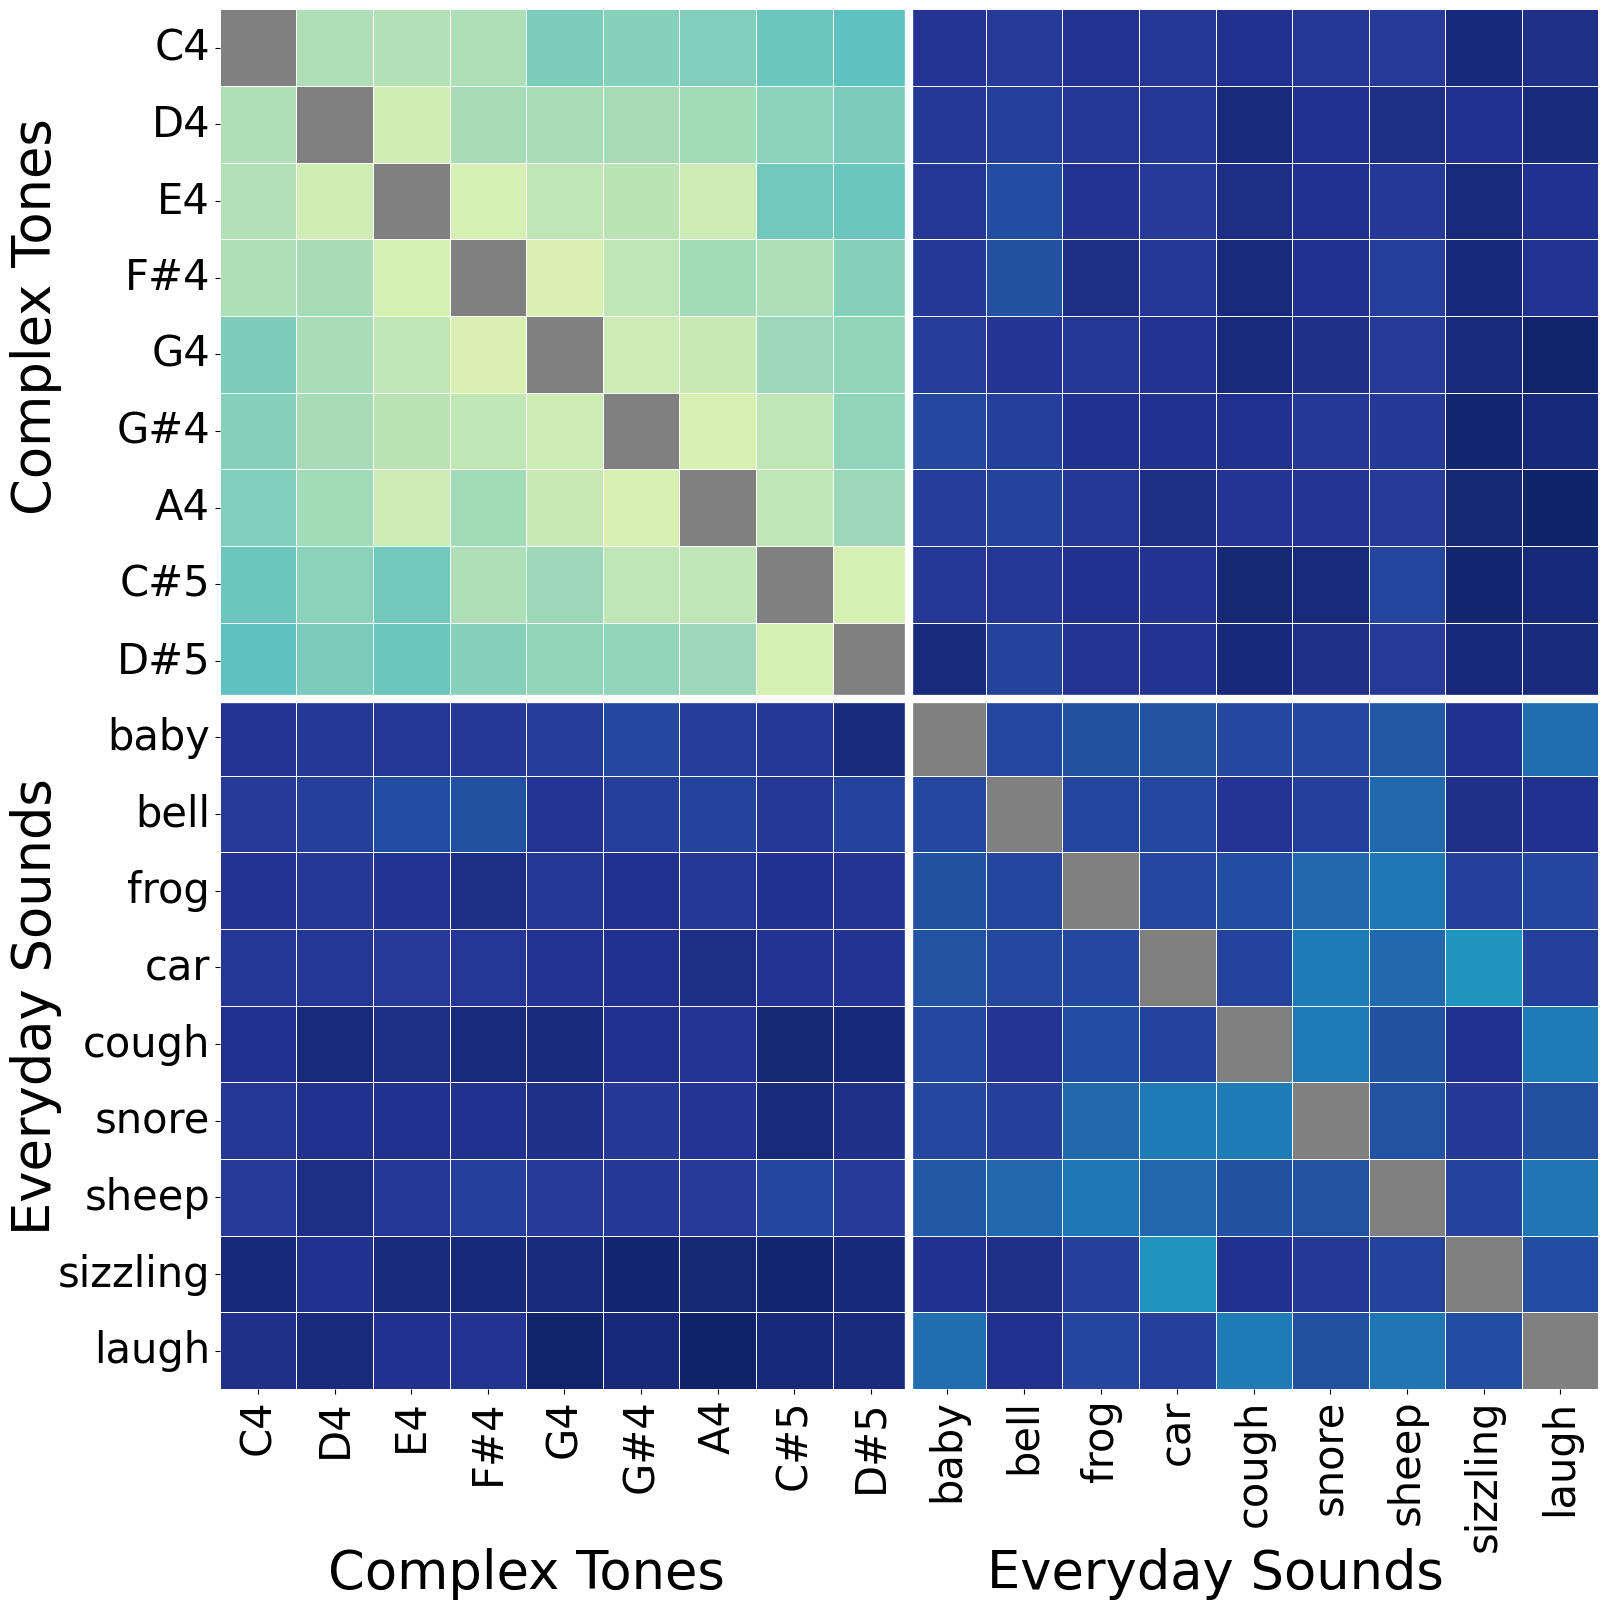

In [15]:
# Create a dissimilarity matrix for each participant and an average matrix
participants = data['Participant Private ID'].unique()
individual_matrices = {participant: create_dissimilarity_matrix(data[data['Participant Private ID'] == participant], complex_tone_names, everydaysound_names) 
                       for participant in participants}
average_matrix = np.mean(np.array([matrix for matrix in individual_matrices.values()]), axis=0)

# Rename complex tones
new_complex_tone_names = ['C4', 'D4', 'E4', 'F#4', 'G4', 'G#4', 'A4', 'C#5', 'D#5']

# Rename everyday sounds by removing '_3ms' and handle specific replacements
new_everydaysound_names = [sound.replace('_3ms', '') for sound in everydaysound_names]
new_everydaysound_names = [sound.replace('car_engine', 'car') for sound in new_everydaysound_names]
new_everydaysound_names = [sound.replace('sizzling_pan', 'sizzling') for sound in new_everydaysound_names]

combined_names = new_complex_tone_names + new_everydaysound_names

# Step 1: Modify the matrix
special_value = -1  # Choose a value that's not in your existing matrix data range
np.fill_diagonal(average_matrix, special_value)

# Step 2: Create a custom colormap
colors = plt.cm.YlGnBu(np.linspace(0.1, 1, 256))
colors[0] = [0.5, 0.5, 0.5, 1]  # RGB for gray with full opacity
custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom', colors)


plt.figure(figsize=(16, 16))
ax = sns.heatmap(average_matrix, cmap=custom_colormap, annot=False, xticklabels=combined_names, yticklabels=combined_names, linewidths=0.5, cbar= False, vmin=0, vmax=6)

# Configure plot aesthetics
ax.xaxis.tick_bottom()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=30)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=30)

# Draw vertical line separating the categories on the x-axis
ax.axvline(9, color='white', linewidth=6)
ax.axhline(9, color='white', linewidth=6)

# Increase the fontsize for custom text
fontsize_label = 38
ax.text(4, 20.4, "Complex Tones", ha="center", va="center", color="black", fontsize=fontsize_label)
ax.text(13, 20.4, "Everyday Sounds", ha="center", va="center", color="black", fontsize=fontsize_label)
ax.text(-2.4, 4, "Complex Tones", ha="center", va="center", color="black", rotation=90, fontsize=fontsize_label)
ax.text(-2.4, 13, "Everyday Sounds", ha="center", va="center", color="black", rotation=90, fontsize=fontsize_label)

#plt.title("Dissimilarity Matrix", fontsize=36)
plt.tight_layout()
plot_individual_path = os.path.join(os.path.dirname(output_csv_path), "individual_RDM_plot.png")
plt.savefig(plot_individual_path)
plt.show()


Stress Ratio: 0.026937962179592812


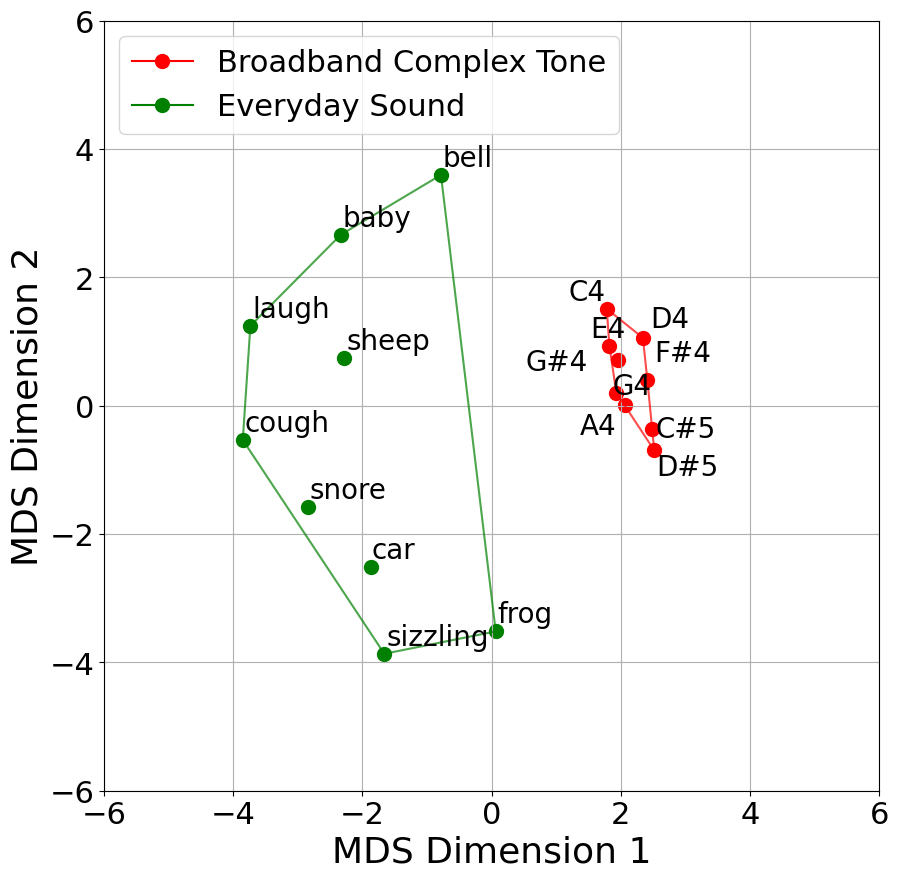

In [16]:
# MDS Analysis
mds = MDS(dissimilarity='precomputed', random_state=42, normalized_stress=False)
individual_coordinates = {participant: mds.fit_transform(matrix) for participant, matrix in individual_matrices.items()}
average_coordinates = mds.fit_transform(average_matrix)

# Access the stress value
stress_value = mds.stress_
#print(f"Stress Value: {stress_value}")
input_disparities = mds.dissimilarity_matrix_  # the original distance matrix used in the MDS fit
stress_ratio = stress_value / np.sum(input_disparities**2)
print(f"Stress Ratio: {stress_ratio}")

# #~~~~~~~~~ Test ~~~~~~~~~~~~~~~
# # Check if matrices are the same
# single_participant_matrix = individual_matrices[list(individual_matrices.keys())[0]] # Extracting the matrix for the single participant
# is_same_matrix = np.array_equal(single_participant_matrix, average_matrix)
# print(f"Matrices are the same: {is_same_matrix}")

# # Check the MDS outputs
# single_participant_coordinates = individual_coordinates[list(individual_coordinates.keys())[0]] # Extracting the coordinates for the single participant

# # Calculate pairwise distances for both sets of coordinates and compare
# from scipy.spatial import distance_matrix
# dist_matrix_individual = distance_matrix(single_participant_coordinates, single_participant_coordinates)
# dist_matrix_average = distance_matrix(average_coordinates, average_coordinates)

# is_same_mds_output = np.allclose(dist_matrix_individual, dist_matrix_average)
# print(f"MDS outputs are the same: {is_same_mds_output}")

# # Find the indices where the matrices differ
# diff_indices = np.where(single_participant_matrix != average_matrix)

# # Print the differing indices and the corresponding values from both matrices
# for index in zip(diff_indices[0], diff_indices[1]): 
#     print(f"Index: {index}, Single Participant Value: {single_participant_matrix[index]}, Average Value: {average_matrix[index]}")

# ~~~~~~~~~~~~~~~ Plot individual and average MDS results ~~~~~~~~~~~~~~~~~~~~~~~~~~
#plot_individual_MDS(individual_coordinates, complex_tone_names + everydaysound_names, complex_tone_names, output_csv_path)
#plot_average_MDS(average_coordinates, complex_tone_names + everydaysound_names, complex_tone_names, output_csv_path)
plot_average_MDS_with_hulls(average_coordinates, complex_tone_names + everydaysound_names, complex_tone_names, everydaysound_names, output_csv_path)

### Interpreting the MDS Plot

#### Distance between Categories:
- The distance between the centroids (average position) of the two categories can provide insights into their perceived dissimilarity.
- A larger distance suggests that participants perceive the two categories as being more distinct or dissimilar from each other.

#### Overlap of Convex Hulls:
- If the convex hulls (or the "boundary") of the two categories overlap, it suggests that there's some perceived similarity between items in those categories.
- Lack of overlap indicates distinct perceptual categories.

#### Position of Individual Stimuli:
- Items located closer to the boundary of their category's convex hull might be perceived as more ambiguous or more similar to items from the other category.
- Items situated deep within their category's hull are likely perceived as prototypical or strongly representative of their category.

#### Understanding the Stress Ratio in MDS

- Multidimensional Scaling (MDS) is a technique used to visualize the structure of complex data in a lower-dimensional space, often two dimensions for easy visualization. One of the critical measures of how well this lower-dimensional representation captures the relationships in the original high-dimensional data is the Stress Ratio.

- The Stress Ratio quantifies the misfit between the distances in the original data and the distances in the MDS representation. 

- **Interpretation Guide**:
  - **Below 0.05**: Excellent representation.
  - **Between 0.05 and 0.1**: Good representation.
  - **Between 0.1 and 0.2**: Fair representation.
  - **Above 0.2**: Potentially poor representation.

In [17]:
# Statistical Analysis for MDS
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_rel

# Assuming complex_tone_names and everydaysound_names are available as lists
# Assuming individual_coordinates is a dict with Participant ID as keys and MDS coordinates as values

everyday_distances = []
complex_distances = []

# Combine the lists
all_stimuli = complex_tone_names + everydaysound_names

for participant, coordinates in individual_coordinates.items():
    
    # Check if the length of the coordinates is as expected
    if len(coordinates) != len(all_stimuli):
        print(f"Unexpected number of coordinates for participant {participant}")
        continue

    # Get indices for each category
    everyday_indices = [all_stimuli.index(sound) for sound in everydaysound_names]
    complex_indices = [all_stimuli.index(tone) for tone in complex_tone_names]

    # Mean coordinates for each category
    everyday_mean = np.mean([coordinates[i] for i in everyday_indices], axis=0)
    complex_mean = np.mean([coordinates[i] for i in complex_indices], axis=0)
    
    # Mean distance of each stimulus to its category mean
    everyday_distance = np.mean([euclidean(coordinates[i], everyday_mean) for i in everyday_indices])
    complex_distance = np.mean([euclidean(coordinates[i], complex_mean) for i in complex_indices])
    
    everyday_distances.append(everyday_distance)
    complex_distances.append(complex_distance)


# Paired t-test
t_stat, p_value = ttest_rel(everyday_distances, complex_distances)

print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.5f}")
# # test
# print("NaN in everyday_distances:", np.isnan(everyday_distances).any())
# print("NaN in complex_distances:", np.isnan(complex_distances).any())

# print(len(everyday_distances), len(complex_distances))
# print("STD of everyday_distances:", np.std(everyday_distances))
# print("STD of complex_distances:", np.std(complex_distances))

# print(everyday_distances[:10])  # Print first 10 distances for everyday sounds
# print(complex_distances[:10])

t-statistic: 15.160, p-value: 0.00000


In [18]:
# Compute the squared distances for each sound to its category mean for complex tones and everyday sounds
complex_squared_distances_all = []
everyday_squared_distances_all = []

all_stimuli = complex_tone_names + everydaysound_names

for participant, coordinates in individual_coordinates.items():
    complex_mean = np.mean([coordinates[i] for i in range(len(complex_tone_names))], axis=0)
    everyday_mean = np.mean([coordinates[i] for i in range(len(complex_tone_names), len(all_stimuli))], axis=0)
    
    complex_squared_distances = [euclidean(coordinates[i], complex_mean)**2 for i in range(len(complex_tone_names))]
    everyday_squared_distances = [euclidean(coordinates[i], everyday_mean)**2 for i in range(len(complex_tone_names), len(all_stimuli))]
    
    complex_squared_distances_all.extend(complex_squared_distances)
    everyday_squared_distances_all.extend(everyday_squared_distances)

complex_variance = np.mean(complex_squared_distances_all)
complex_std_dev = np.sqrt(complex_variance)

everyday_variance = np.mean(everyday_squared_distances_all)
everyday_std_dev = np.sqrt(everyday_variance)

print(f"Complex Tones: Variance = {complex_variance:.2f}, Std. Dev = {complex_std_dev:.2f}")
print(f"Everyday Sounds: Variance = {everyday_variance:.2f}, Std. Dev = {everyday_std_dev:.2f}")


Complex Tones: Variance = 0.82, Std. Dev = 0.91
Everyday Sounds: Variance = 9.34, Std. Dev = 3.06
